In [ ]:
#
# Run this cell to set up
#

import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from datetime import datetime
import seaborn as sns
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import re
import os
from os.path import join, abspath, dirname, exists

base_url = 'https://andresvidal.github.io/speedtracker-jet'
data_path = join(os.getcwd(), 'wpt_data')
temp_path = join(os.getcwd(), 'wpt_temp')

#### GET DATA ################################

def get_speedtracker_tests(profile_slug):
    data = requests.get(f'{base_url}/profiles.json').json()
    st_tests = {}
    for i, profile in enumerate(data):
        st_tests[profile['slug']] = []
        for test in profile['tests']:
            date = str(test)
            r_json = f"{base_url}/results/{profile['slug']}/{date[:4]}/{date[-2:]}.json"
            st_tests[profile['slug']].append(r_json)
    return st_tests[profile_slug]

def get_speedtracker_wpt_ids(speedtracker_tests):
    wpt_ids = []
    for test in speedtracker_tests:
        t = requests.get(test)
        data = t.json()
        wpt_ids = wpt_ids + data['_r']['id']
    return wpt_ids

def get_missing_wpt_tests(missing_tests_csv, slug=None):
    '''Returns tuple (DataFrame, list) of missing tests by slug'''
    try:
        mdf = pd.read_csv(missing_tests_csv, index_col=None)
        return (mdf, mdf['wpt_id'].unique().tolist())
    except:
        return (pd.DataFrame(), [])

def get_wpt_tests(wpt_ids, slug='test', save=True):
    ts = datetime.now().strftime("%Y-%m-%d-%H%M")
    
    csv_file = join(data_path, f"{slug}.csv")
    missing_tests_csv = join(data_path, f"missing_wpt_tests.csv")
    
    print(f"{ts} Getting tests for {slug} profile...")
    
    # returns mdf DataFrame, a list of ids
    mdf, missing_wpt_ids = get_missing_wpt_tests(missing_tests_csv)
    
    missing_tests = 0
    new_tests = 0
    
    # Load csv if exists
    try:
        wpt_df = pd.read_csv(csv_file, index_col=None)
        tests_exist = wpt_df['data.id'].tolist() + missing_wpt_ids
        collection = [wpt_df]
    except FileNotFoundError:
        tests_exist = [] + missing_wpt_ids
        collection = []
    
    for test in wpt_ids:
        if test not in tests_exist:
            wpt = requests.get(f'https://www.webpagetest.org/result/{test}/?f=json').json()
            try:
                # del large data keys
                delkeys = ['median', 'lighthouse', 'runs', 'standardDeviation']
                for key in delkeys:
                    if key in wpt['data'].keys():
                        del wpt['data'][key]

                ts = wpt['data']['completed']
                wpt['speedtracker.slug'] = slug
                wpt['speedtracker.year'] = datetime.fromtimestamp(ts).strftime('%Y')
                wpt['speedtracker.month'] = datetime.fromtimestamp(ts).strftime('%m')
                wpt['speedtracker.day'] = datetime.fromtimestamp(ts).strftime('%d')
                wpt['speedtracker.week'] = datetime.fromtimestamp(ts).isocalendar()[1]

                # flatten JSON
                collection.append( json_normalize(wpt) )
                
                new_tests += 1
            except Exception as e:
                statusText = wpt.get('statusText', e)
                if 'Test not found' in statusText:
                    missing_tests += 1
                    mdf = mdf.append( pd.DataFrame([[test, slug, ts]], 
                                                   columns=['wpt_id', 'speedtracker.slug', 'timestamp']) )
                    #print('get_wpt_tests exception:', statusText, test, slug)

    wpt_df = pd.concat(collection).drop_duplicates(subset='data.id', inplace=False).reset_index(drop=True)
    
    if save:
        if not exists(data_path):
            os.makedirs(data_path)
            print("{ts} Created Directory " , data_path)
        
        if new_tests > 0:
            print(f"{ts} Saving: {csv_file}")
            wpt_df.to_csv(csv_file, index=False)
        
        if missing_tests > 0:
            print(f"{ts} Saving: {missing_tests_csv}")
            mdf.to_csv(missing_tests_csv, index=False)
        
    print(f"{ts} Done with {slug}. WPT is missing {missing_tests} tests.\n")
    return wpt_df


def get_wpt_from_speedtracker_tests(profile_slug, save=True):
    speedtracker_tests = get_speedtracker_tests(profile_slug)
    wpt_ids = get_speedtracker_wpt_ids(speedtracker_tests)
    get_wpt_tests(wpt_ids, slug=profile_slug, save=save)
    
#### PARSE DATA ################################

def get_pagetype(profile_slug):
    '''Pagetype regex for Jet profiles only. like: browse22 = browse'''
    pagetype = re.search(r'([a-z]+)', profile_slug)
    if pagetype:
        pagetype = pagetype.group(0)
    return pagetype

def compare(before, after, profile_slug='', fromdates='', todates=''):
    data = {}
    for item in after:
        data[item] = {}
        data[item][f'{profile_slug} {fromdates} (before - avg)'] = before[item]
        data[item][f'{profile_slug} {todates} (after - avg)'] = after[item]
        #data[item][f'{profile_slug} delta (seconds)'] = after[item] - before[item]
        data[item][f'{profile_slug} delta %'] = round(((after[item] - before[item])/before[item])*100, 2)
    return data

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    # Carefull... returns full df but filters out outlier rows only
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

def validate_outliers(df, col_name, start_date=None, end_date=None):
    if start_date and end_date:
        df['date'] = pd.to_datetime(df['data.completed'], unit='s') 
        mask = (df['date'] > parse(start_date)) & (df['date'] <= parse(end_date))
        df = df[mask]

    sns.boxplot(df[col_name])

def mean(profile_slug, start_date, end_date, counts=False):
    csv_file = join(data_path, f"{profile_slug}.csv")
    
    # Choose metrics to include in average calculations
    metrics  = ['data.average.firstView.TTFB', 
                
                'data.average.firstView.firstPaint',
                #'data.average.firstView.PerformancePaintTiming.first-paint',
                
                'data.average.firstView.firstContentfulPaint',
                #'data.average.firstView.PerformancePaintTiming.first-contentful-paint',
                #'data.average.firstView.chromeUserTiming.firstContentfulPaint',
                
                'data.average.firstView.firstMeaningfulPaint',
                
                'data.average.firstView.FirstInteractive',
                'data.average.firstView.TimeToInteractive',
                'data.average.firstView.domInteractive',
                #'data.average.firstView.LastInteractive',
                
                'data.average.firstView.SpeedIndex',
                'data.average.firstView.fullyLoaded',
                ]
    
    df = pd.read_csv(csv_file)
    df['date'] = pd.to_datetime(df['data.completed'], unit='s') 
    
    #adding 1 day assumes comparison with top of the previous day. Note: exact end_date with hours will not work.
    mask = (df['date'] > parse(start_date)) & (df['date'] < parse(end_date)+relativedelta(days=+1))
    df = df[mask]
    
    dfo = {}
    for metric in metrics:
        # remove outliers and get mean per metric.
        dfo[metric] = round(remove_outlier(df, metric)[metric].mean() / 1000, 3) # seconds
        #print(f'{profile_slug} {metric} {dfo[metric]}')
        if counts:
            dfo[f'{metric}_count'] = df[metric].count()
    
    return dfo
    #return df
    
def run_compare(profile_slugs, from_start, from_end, to_start, to_end):
    collection = []
    from_date_range = f"{from_start}_{from_end}"
    to_date_range = f"{to_start}_{to_end}"
    
    if type(profile_slugs) == str:
        profile_slugs = [profile_slugs]
    
    for profile_slug in profile_slugs:
        before = mean(profile_slug, from_start, from_end)
        after = mean(profile_slug, to_start, to_end)

        # times will be in seconds
        results = compare(before, after, profile_slug, from_date_range, to_date_range)
        collection.append(pd.DataFrame( results ) )

    return pd.concat(collection)

In [ ]:
#
# Run this cell to download the following profile data from webpagetest as csv files
# See first cell to update: data_path = path
# Run first cell again if modified
#

speedtracker_profiles_download = [
 'home',
 'home-noanalytics',
 'product22',
 'product2',
 'product2-noanalytics',
 'product24',
 'product25',
 'product27',
 'browse22',
 'browse24',
 'browse26',
 'search',
 'search23',
 'search26',
 
 'walmart-home',
 'target-home',
 'nike-home',
 'amazon-home',
 'bhphoto-home',
 'bhphoto-browse',
 'bhphoto-product',
 'bhphoto-search',
 'airbnb-home',
 'airbnb-homes',
 'flipkart-home',
 'freshdirect-home',
 'freshdirect-browse',
 'freshdirect-product',
 'freshdirect-search',
 'apple-home']

for profile in speedtracker_profiles_download:
    get_wpt_from_speedtracker_tests(profile)

In [ ]:
# 
# Define profiles to analyze
# 

speedtracker_profiles = [
    'home',
    'product22',
    'product2',
    'product24',
    'product25',
    'product27',
    'browse22',
    'browse24',
    'browse26',
    'search',
    'search23',
    'search26']

In [194]:
#
# Use 2 weeks or more when comparing in order to avoid overpowering outliers within small samples
#
#
# Pull data for the profiles defined above and save to csv
# run_compare(profile_slugs, from_start, from_end, to_start, to_end)
# 

ts = datetime.now().strftime("%Y%m%d%H%M")

#
# Pre-determined run dates below based on batman sprint cycles 
#

#df = run_compare(speedtracker_profiles, '2019/01/13', '2019/01/26', '2019/01/27', '2019/02/09') # 2/2 weeks

#df = run_compare(speedtracker_profiles, '2019/01/27', '2019/02/09', '2019/02/10', '2019/02/16') # 2/1 weeks
#df = run_compare(speedtracker_profiles, '2019/01/27', '2019/02/09', '2019/02/10', '2019/02/23') # 2/2 weeks

df = run_compare(speedtracker_profiles, '2019/02/10', '2019/02/23', '2019/02/24', '2019/03/02') # 2/1 weeks
#df = run_compare(speedtracker_profiles, '2019/02/10', '2019/02/23', '2019/02/24', '2019/03/09') # 2/2 weeks

#df = run_compare(speedtracker_profiles, '2019/02/24', '2019/03/09', '2019/03/10', '2019/03/16') # 2/1 weeks
#df = run_compare(speedtracker_profiles, '2019/02/24', '2019/03/09', '2019/03/10', '2019/03/23') # 2/2 weeks

#df = run_compare(speedtracker_profiles, '2019/03/10', '2019/03/23', '2019/03/24', '2019/03/30') # 2/1 weeks
#df = run_compare(speedtracker_profiles, '2019/03/10', '2019/03/23', '2019/03/24', '2019/04/06') # 2/2 weeks

#df = run_compare(speedtracker_profiles, '2019/03/24', '2019/04/06', '2019/04/07', '2019/04/13') # 2/1 weeks
#df = run_compare(speedtracker_profiles, '2019/03/24', '2019/04/06', '2019/04/07', '2019/04/20') # 2/2 weeks

# Save
df.to_csv(join(temp_path, f'speedtracker-analysis_{ts}.csv'))

# Show data table. Comment to ignore showing.
df

,data.average.firstView.FirstInteractive,data.average.firstView.SpeedIndex,data.average.firstView.TTFB,data.average.firstView.TimeToInteractive,data.average.firstView.domInteractive,data.average.firstView.firstContentfulPaint,data.average.firstView.firstMeaningfulPaint,data.average.firstView.firstPaint,data.average.firstView.fullyLoaded
home 2019/02/10_2019/02/23 (before - avg),3.449,4.389,1.762,2.362,3.271,3.432,4.243,3.432,17.866
home 2019/02/24_2019/03/02 (after - avg),3.532,3.802,1.776,2.373,3.261,3.529,4.291,3.529,17.803
home delta %,2.410,-13.370,0.790,0.470,-0.310,2.830,1.130,2.830,-0.350
product22 2019/02/10_2019/02/23 (before - avg),3.275,5.651,1.696,3.202,3.211,3.243,7.256,3.243,22.667
product22 2019/02/24_2019/03/02 (after - avg),3.422,3.992,1.846,3.349,3.345,3.406,3.436,3.406,22.925
product22 delta %,4.490,-29.360,8.840,4.590,4.170,5.030,-52.650,5.030,1.140
product2 2019/02/10_2019/02/23 (before - avg),3.242,4.207,1.710,3.214,3.174,3.264,8.417,3.264,18.650
product2 2019/02/24_2019/03/02 (after - avg),3.347,3.763,1.787,NaN,3.265,3.333,8.479,3.334,18.926
product2 delta %,3.240,-10.550,4.500,NaN,2.870,2.110,0.740,2.140,1.480
product24 2019/02/10_2019/02/23 (before - avg),3.281,5.350,1.678,3.253,3.211,3.262,3.262,3.262,20.597


In [ ]:
#
# Run to calculate and save Percentage Changes for profiles defined above
#

df_p = df[df.index.str.contains('%')].sort_values(by=['data.average.firstView.FirstInteractive', 'data.average.firstView.firstMeaningfulPaint'])
df_p.to_csv(join(temp_path, f'speedtracker-analysis_pct_chng_{ts}.csv'))


In [ ]:
#
# Run to Validate Outliers for given dates and metric (use full name with dot-notation)
# Uses defined profiles from previous cell
#
# Update dates and metrics below before running
# Note: you can uncomment/comment out removing outliers below...
#

start_date = '2019/02/24'
end_date = '2019/03/02'
metric = 'data.average.firstView.firstPaint'
rmv_outliers = True

boxplot_collection = []

for profile_slug in speedtracker_profiles:
    _df = pd.read_csv(join(data_path, f'{profile_slug}.csv'))
    _df['date'] = pd.to_datetime(_df['data.completed'], unit='s')
    _mask = (_df['date'] > parse(start_date)) & (_df['date'] < parse(end_date)+relativedelta(days=+1))
    _dfmasked = _df[_mask]
    
    if rmv_outliers:
        _dfmasked = remove_outlier(_dfmasked, metric)
    
    boxplot_collection.append(_dfmasked)

print(f"Date Range: {start_date} to {end_date} \nRemove Outliers: {rmv_outliers}")
boxplot_df = pd.concat(boxplot_collection)
sns.set(rc={'figure.figsize':(15,8.27)})
sns.boxplot(x='speedtracker.slug', y=metric,width=.7, data=boxplot_df)

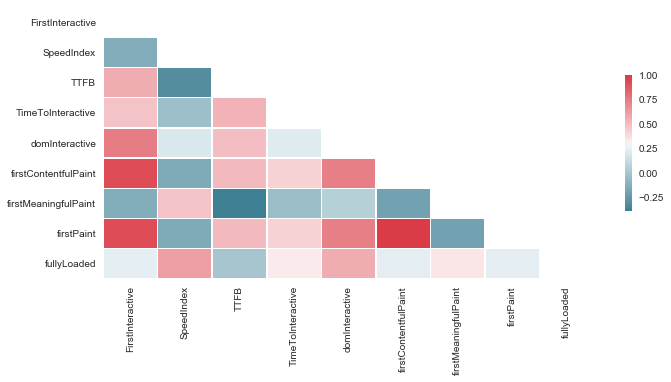

In [218]:
#
# Plotting a diagonal correlation matrix
#

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.rename(dict(zip(
        list(df.columns), 
        list(df.columns.str.split('.').map(lambda r: r[-1])) 
    )), axis=1).corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)



# sns.heatmap(corr, mask=mask, cmap=cmap, center=0, robust=1,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

sns.heatmap(corr, mask=mask, cmap=cmap, robust=1,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})